# Overview

Initial look and cleaning and seperating of data complete.

To accomplish: 

- select better model for fitting
- select cleaner way to impute data
- try pca
- make month specific predictions (opt)

# Initial Imports

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
zillow_data_dictionary = pd.read_excel('data/zillow_data_dictionary.xlsx')
train_2016 = pd.read_csv('data/train_2016_v2.csv')
properties_2016 = pd.read_csv('data/properties_2016.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

C:\Users\Josh\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Zillow Data Dictionary

##### zdd is a description of each of the features available for analysis

In [3]:
zillow_data_dictionary.head()

,Feature,Description
0,'airconditioningtypeid',Type of cooling system present in the home (i...
1,'architecturalstyletypeid',"Architectural style of the home (i.e. ranch, ..."
2,'basementsqft',Finished living area below or partially below...
3,'bathroomcnt',Number of bathrooms in home including fractio...
4,'bedroomcnt',Number of bedrooms in home


In [4]:
zdd = zillow_data_dictionary

In [5]:
zdd['Feature'].unique()

array(["'airconditioningtypeid'", "'architecturalstyletypeid'",
       "'basementsqft'", "'bathroomcnt'", "'bedroomcnt'",
       "'buildingqualitytypeid'", "'buildingclasstypeid'",
       "'calculatedbathnbr'", "'decktypeid'", "'threequarterbathnbr'",
       "'finishedfloor1squarefeet'", "'calculatedfinishedsquarefeet'",
       "'finishedsquarefeet6'", "'finishedsquarefeet12'",
       "'finishedsquarefeet13'", "'finishedsquarefeet15'",
       "'finishedsquarefeet50'", "'fips'", "'fireplacecnt'",
       "'fireplaceflag'", "'fullbathcnt'", "'garagecarcnt'",
       "'garagetotalsqft'", "'hashottuborspa'", "'heatingorsystemtypeid'",
       "'latitude'", "'longitude'", "'lotsizesquarefeet'",
       "'numberofstories'", "'parcelid'", "'poolcnt'", "'poolsizesum'",
       "'pooltypeid10'", "'pooltypeid2'", "'pooltypeid7'",
       "'propertycountylandusecode'", "'propertylandusetypeid'",
       "'propertyzoningdesc'", "'rawcensustractandblock'",
       "'censustractandblock'", "'regionidcounty'

In [6]:
zdd.loc[0][0]

"'airconditioningtypeid'"

In [7]:
zdd.loc[0][1]

' Type of cooling system present in the home (if any)'

# Train 2016

### All of the train information from 2016

- parcel id
- log error
- transaction date
- month

In [8]:
train_2016.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


In [9]:
train = train_2016

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90275 entries, 0 to 90274
Data columns (total 3 columns):
parcelid           90275 non-null int64
logerror           90275 non-null float64
transactiondate    90275 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ MB


In [11]:
#date is year month day

In [12]:
int(train.loc[0][2].split('-')[1]) #Extracting the month

1

In [13]:
#create month column - numeric
train['month']=train['transactiondate'].apply(lambda date: int(date.split('-')[1])) 

In [14]:
train.drop('transactiondate',axis=1,inplace=True)

In [15]:
train.head(1)

,parcelid,logerror,month
0,11016594,0.0276,1


In [16]:
train.groupby('month').mean()

,parcelid,logerror
month,,
1,1.291135e+07,0.015870
2,1.296204e+07,0.016082
3,1.299837e+07,0.009867
4,1.300473e+07,0.006605
5,1.304167e+07,0.006926
6,1.303634e+07,0.007172
7,1.298525e+07,0.011687
8,1.299474e+07,0.011573
9,1.294000e+07,0.016255


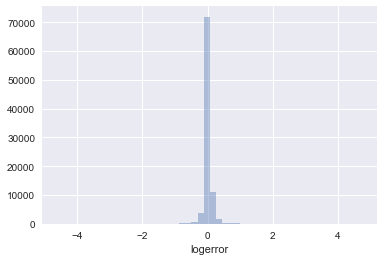

In [17]:
sns.distplot(train['logerror'],kde=False)

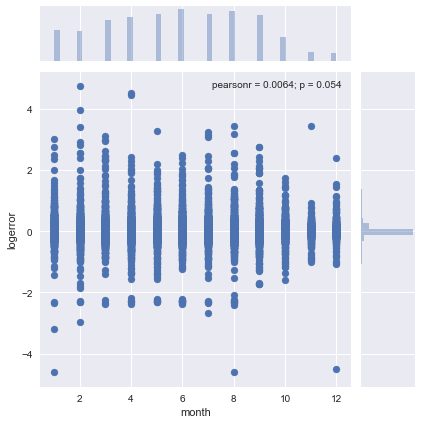

In [18]:
sns.jointplot(x='month',y='logerror',data=train)

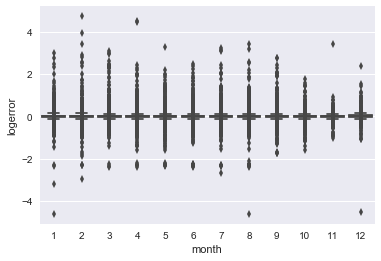

In [19]:
sns.boxplot(x='month',y='logerror',data=train)

# Propeties 2016

### Property data

1 id column
57 feature columns

In [20]:
prop_train = pd.merge(properties_2016,train_2016,how='inner',on='parcelid')

In [21]:
prop_train.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,logerror,month
0,17073783,NaN,NaN,NaN,2.5,3.0,NaN,NaN,2.5,NaN,...,115087.0,191811.0,2015.0,76724.0,2015.06,NaN,NaN,6.111002e+13,0.0953,1
1,17088994,NaN,NaN,NaN,1.0,2.0,NaN,NaN,1.0,NaN,...,143809.0,239679.0,2015.0,95870.0,2581.30,NaN,NaN,6.111002e+13,0.0198,3
2,17100444,NaN,NaN,NaN,2.0,3.0,NaN,NaN,2.0,NaN,...,33619.0,47853.0,2015.0,14234.0,591.64,NaN,NaN,6.111001e+13,0.0060,5
3,17102429,NaN,NaN,NaN,1.5,2.0,NaN,NaN,1.5,NaN,...,45609.0,62914.0,2015.0,17305.0,682.78,NaN,NaN,6.111001e+13,-0.0566,6
4,17109604,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,NaN,...,277000.0,554000.0,2015.0,277000.0,5886.92,NaN,NaN,6.111001e+13,0.0573,8


In [22]:
prop=properties_2016

In [23]:
prop.head()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


In [24]:
#properties_2016.iloc[0:100]

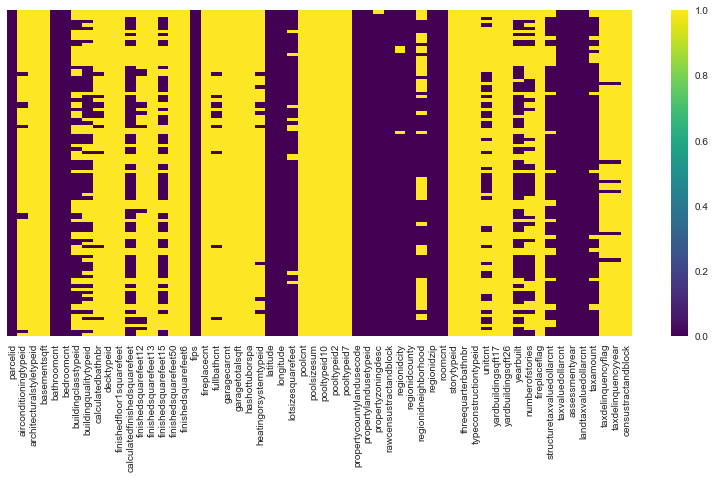

In [25]:
#looking at missing values
plt.figure(figsize=(14,6))
sns.heatmap(prop.iloc[0:100].isnull(),yticklabels=False,cmap='viridis')

In [175]:
rarely_missing_data_columns=list(prop_sample.dropna(axis=1,thresh=2970000).columns) #Columns with rarely missing data (<10)
rarely_missing_data_columns

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'fips',
 'latitude',
 'longitude',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'assessmentyear']

In [129]:
#prop.dropna(axis=1,thresh=2985100,inplace=True)

In [176]:
prop = prop[rarely_missing_data_columns]

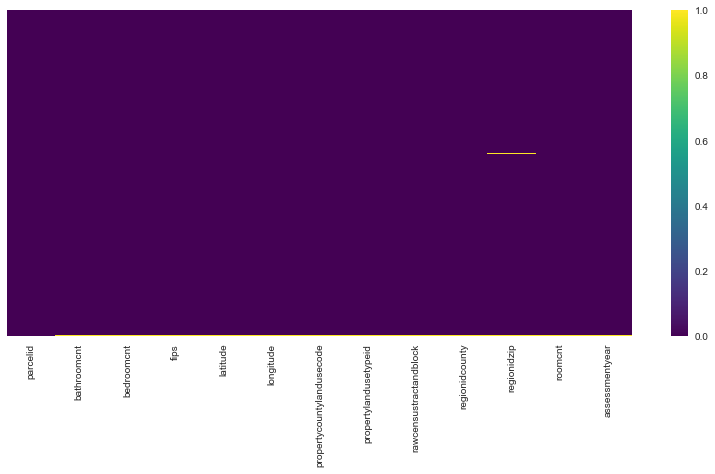

In [177]:
#looking at missing values
plt.figure(figsize=(14,6))
sns.heatmap(prop.isnull(),yticklabels=False,cmap='viridis')

#### Deal with missing data

In [204]:
missing_df = prop.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column name', 'missing count']
missing_df = missing_df.sort_values(by='missing count',ascending=False)
missing_df.head(12)

,column name,missing count
11,roomcnt,11475
1,bathroomcnt,11462
2,bedroomcnt,11450
12,assessmentyear,11439
3,fips,11437
4,latitude,11437
5,longitude,11437
7,propertylandusetypeid,11437
8,rawcensustractandblock,11437
9,regionidcounty,11437


In [180]:
#prop[prop.isnull().any(axis=1)==True].head(1)

,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,assessmentyear
119,13113147,0.0,0.0,6037.0,33984307.0,-118453193.0,NaN,266.0,6.037703e+07,3101.0,96128.0,0.0,2015.0


In [191]:
#most common zip code
#most_common_zip = prop['regionidzip'].value_counts().idxmax()
#most_common_zip

96987.0

In [192]:
#most common propertycountylandusecode
#most_common_propertycountylandusecode = prop['propertycountylandusecode'].value_counts().idxmax()
#most_common_propertycountylandusecode 

'0100'

#### Impute most common zip and land codes

In [205]:
#Zip
#prop['regionidzip'].fillna(float(most_common_zip), inplace=True)

#Land Code
#prop['propertycountylandusecode'].fillna(most_common_propertycountylandusecode, inplace=True)

In [206]:
for column in prop.columns:
    prop[column].fillna(prop[column].value_counts().idxmax(), inplace=True)

C:\Users\Josh\Anaconda3\lib\site-packages\pandas\core\generic.py:3549: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [207]:
prop[prop.isnull().any(axis=1)==True] # no more null statements

,parcelid,bathroomcnt,bedroomcnt,fips,latitude,longitude,propertycountylandusecode,propertylandusetypeid,rawcensustractandblock,regionidcounty,regionidzip,roomcnt,assessmentyear


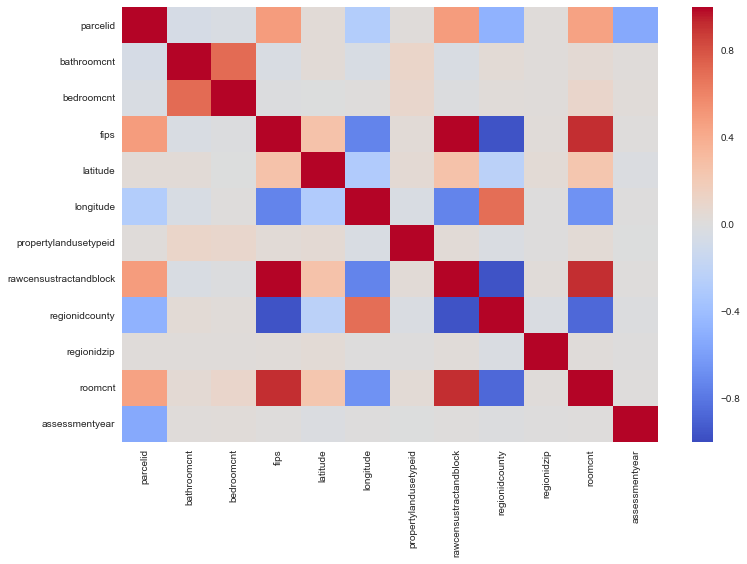

In [168]:
plt.figure(figsize=(12,8))
sns.heatmap(prop_sample.corr(),cmap='coolwarm')

# Fully cleaned properties

In [122]:
def remove_outliers(old_df,number_of_std,columns="All",skip="None"):
    """
    Removes outliers from a dataframe.
    
    Parameters:
    old_df: Series or dataframe
    
    number_of_std: Number of standard deviations for threshhold. 
                   Function will remove all outliers beyond this many standard deviations.
                   
    columns: The columns upon which the operation will be performed. (List of column names)
    
    skip: List of columns to be skipped.
    
    Returns:
    A dataframe with the outliers removed.
    
    """
    
    if isinstance(old_df,pd.core.series.Series): #If series passed, then only 
        current_series = old_df #set current series
        
        mean = np.mean(current_series)    #Mean
        std = np.std(current_series)      #Std
        threshold = number_of_std*std     #Threshhold = number of std * std
        
        new_df = old_df[np.abs(current_series-mean)<threshold] #Remove outliers from series
    else:
        if columns=="All": #Set columns
            columns=old_df.columns
            
        if skip!="None": #Skip any columns to be skipped
            columns = [name for name in list(old_df.columns) if name not in skip]
        
        for column in columns:
            current_series = old_df[column] #Iterate through each column

            mean = np.mean(current_series) #Set up threshold for which x should be within
            std = np.std(current_series)
            threshold = number_of_std*std

            new_df = old_df[np.abs(current_series-mean)<threshold] #Remove outliers from this column
    
    return new_df

In [46]:
len(prop)

2985217

In [47]:
sub_2 = list(prop.dropna(axis=1,thresh=2970000).columns) 
sub_2

['parcelid',
 'bathroomcnt',
 'bedroomcnt',
 'fips',
 'latitude',
 'longitude',
 'propertycountylandusecode',
 'propertylandusetypeid',
 'rawcensustractandblock',
 'regionidcounty',
 'regionidzip',
 'roomcnt',
 'assessmentyear']

In [48]:
sub_2 = sub_2

In [49]:
prop[sub_2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2985217 entries, 0 to 2985216
Data columns (total 13 columns):
parcelid                     int64
bathroomcnt                  float64
bedroomcnt                   float64
fips                         float64
latitude                     float64
longitude                    float64
propertycountylandusecode    object
propertylandusetypeid        float64
rawcensustractandblock       float64
regionidcounty               float64
regionidzip                  float64
roomcnt                      float64
assessmentyear               float64
dtypes: float64(11), int64(1), object(1)
memory usage: 296.1+ MB


In [50]:
#zillow_data_dictionary

In [51]:
prop['assessmentyear'].unique()

array([ 2015.,  2014.,  2003.,  2012.,  2001.,  2011.,  2013.,  2016.,
        2010.,    nan,  2004.,  2005.,  2002.,  2000.,  2009.])

In [52]:
cleaned_prop = prop[sub_2].drop(['propertycountylandusecode','propertylandusetypeid',
                                 'rawcensustractandblock','regionidcounty','fips'],axis=1)

cleaned_prop['regionidzip'].fillna('96193.0', inplace=True)
cleaned_prop['regionidzip'] = cleaned_prop['regionidzip'].apply(float)

cleaned_prop['bathroomcnt'].fillna(cleaned_prop['bathroomcnt'].mean(),inplace=True)

cleaned_prop['bedroomcnt'].fillna(cleaned_prop['bedroomcnt'].mean(),inplace=True)

cleaned_prop['roomcnt'].fillna(cleaned_prop['bedroomcnt']+cleaned_prop['bathroomcnt'],inplace=True)

cleaned_prop['assessmentyear'].fillna(cleaned_prop['assessmentyear'].mean(),inplace=True)

cleaned_prop['latitude'].fillna(cleaned_prop['latitude'].mean(),inplace=True)

cleaned_prop['longitude'].fillna(cleaned_prop['longitude'].mean(),inplace=True)


cleaned_prop[cleaned_prop.isnull().any(axis=1)==True] # no more null statements

,parcelid,bathroomcnt,bedroomcnt,latitude,longitude,regionidzip,roomcnt,assessmentyear


In [123]:
cleaned_prop = remove_outliers(cleaned_prop,3,skip=['parcelid','regionidzip','assessmentyear']) 

#### Seperate properties with pricing data from properties without pricing data

In [81]:
X_train = cleaned_prop[cleaned_prop['parcelid'].isin(train_2016['parcelid'])]#pd.merge(prop4,train_2016,how='inner',on='parcelid')
X_test = cleaned_prop[~cleaned_prop['parcelid'].isin(train_2016['parcelid'])]

In [82]:
X_test.count()

parcelid          2895067
bathroomcnt       2895067
bedroomcnt        2895067
latitude          2895067
longitude         2895067
regionidzip       2895067
roomcnt           2895067
assessmentyear    2895067
dtype: int64

In [83]:
X_train.count()

parcelid          90150
bathroomcnt       90150
bedroomcnt        90150
latitude          90150
longitude         90150
regionidzip       90150
roomcnt           90150
assessmentyear    90150
dtype: int64

# Setting y_train and aligning x_train and y_train

In [84]:
y_train = train_2016.groupby('parcelid')['logerror'].mean()

In [85]:
#Aligning train_y and train_x
X_train = X_train.sort_values('parcelid')
y_train = y_train.reset_index().sort_values('parcelid')

# Model: XGBoost

#### Initial set-up

In [53]:
features = list(cleaned_prop.columns)

In [86]:
xgb_model = xgb.XGBRegressor()

In [87]:
from sklearn.model_selection import train_test_split

In [88]:
Xtr, Xv, ytr, yv = train_test_split(X_train.drop('parcelid',axis=1).values, 
                                    y_train.drop('parcelid',axis=1).values, 
                                    test_size=0.2, random_state=42)

In [89]:
dtrain = xgb.DMatrix(Xtr, label=ytr)
dvalid = xgb.DMatrix(Xv, label=yv)

dtest = xgb.DMatrix(X_test.drop('parcelid',axis=1).values)
watchlist = [(dtrain,'dtrain'),(dvalid,'dvalid')]
#watchlist = [(dtrain,'training_set'),(dvalid,'validation_set')]

#### Gridsearch parameters for XGBoost

In [90]:
from sklearn.model_selection import GridSearchCV

In [94]:
param_grid = [{'min_child_weight':[1,10],'max_depth':[3,6,10]}]

xgb_model = xgb.XGBRegressor(n_jobs=-1)

grid_search = GridSearchCV(xgb_model, param_grid, cv=3,verbose=1)

grid_search.fit(X_train.drop('parcelid',axis=1),y_train.drop('parcelid',axis=1))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   48.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'min_child_weight': [1, 10], 'max_depth': [3, 6, 10]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [95]:
params = grid_search.best_params_
params

{'max_depth': 6, 'min_child_weight': 10}

#### Train XGBoost

In [96]:
xgbr = xgb.train(params=params,
                 dtrain=dtrain,
                 num_boost_round=100,
                 evals=watchlist,
                 early_stopping_rounds=30,
                 maximize=False,
                verbose_eval=10)

[0]	dtrain-rmse:0.37724	dvalid-rmse:0.380888
Multiple eval metrics have been passed: 'dvalid-rmse' will be used for early stopping.

Will train until dvalid-rmse hasn't improved in 30 rounds.
[10]	dtrain-rmse:0.15806	dvalid-rmse:0.16449
[20]	dtrain-rmse:0.157305	dvalid-rmse:0.164173
[30]	dtrain-rmse:0.156848	dvalid-rmse:0.164275
[40]	dtrain-rmse:0.156127	dvalid-rmse:0.164329
Stopping. Best iteration:
[17]	dtrain-rmse:0.157466	dvalid-rmse:0.164157



In [97]:
xgbr.best_score

0.164157

#### Feature Importance

In [98]:
feature_importance_dict = xgbr.get_fscore()
feature_importance = pd.DataFrame({'feature': list(feature_importance_dict.keys()),
                                   'importance': list(feature_importance_dict.values())})
feature_importance['feature']=feature_importance['feature'].apply(lambda feature_id: features[int(list(feature_id)[1])])

feature_importance[['feature', 'importance']].sort_values(by='importance', ascending=False)

,feature,importance
1,bedroomcnt,337
2,latitude,251
3,longitude,82
0,parcelid,60
5,bathroomcnt,55
4,regionidzip,29


#### Predictions

In [99]:
pred = xgbr.predict(dtest)

# Compile predictions

#### Create test_pred_df

Currently from singular prediction.

In [100]:
test_pred_df = pd.DataFrame(data=X_test['parcelid'],columns=['parcelid'])

#For now - set all predictions alike irrespective of month

test_pred_df['201610']= pred
test_pred_df['201611']= pred
test_pred_df['201612']= pred
test_pred_df['201710']= pred
test_pred_df['201711']= pred
test_pred_df['201712']= pred

test_pred_df.head()

,parcelid,201610,201611,201612,201710,201711,201712
0,10754147,0.004719,0.004719,0.004719,0.004719,0.004719,0.004719
1,10759547,0.004719,0.004719,0.004719,0.004719,0.004719,0.004719
2,10843547,-0.010164,-0.010164,-0.010164,-0.010164,-0.010164,-0.010164
3,10859147,-0.012443,-0.012443,-0.012443,-0.012443,-0.012443,-0.012443
4,10879947,-0.001875,-0.001875,-0.001875,-0.001875,-0.001875,-0.001875


#### Create train_pred_df from train data

In [101]:
train_pred_df = pd.DataFrame(data=y_train['parcelid'],columns=['parcelid'])

#For now - set all predictions alike irrespective of month
train_pred_df['201610']= y_train['logerror']
train_pred_df['201611']= y_train['logerror']
train_pred_df['201612']= y_train['logerror']
train_pred_df['201710']= y_train['logerror']
train_pred_df['201711']= y_train['logerror']
train_pred_df['201712']= y_train['logerror']

train_pred_df.head()
train_pred_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90150 entries, 0 to 90149
Data columns (total 7 columns):
parcelid    90150 non-null int64
201610      90150 non-null float64
201611      90150 non-null float64
201612      90150 non-null float64
201710      90150 non-null float64
201711      90150 non-null float64
201712      90150 non-null float64
dtypes: float64(6), int64(1)
memory usage: 5.5 MB


#### Merge train_pred_df and test_pred_df

In [102]:
sub_df = pd.merge(train_pred_df,test_pred_df,how='outer',on='parcelid')
sub_df.head()

,parcelid,201610_x,201611_x,201612_x,201710_x,201711_x,201712_x,201610_y,201611_y,201612_y,201710_y,201711_y,201712_y
0,10711738,0.0276,0.0276,0.0276,0.0276,0.0276,0.0276,NaN,NaN,NaN,NaN,NaN,NaN
1,10711755,-0.0182,-0.0182,-0.0182,-0.0182,-0.0182,-0.0182,NaN,NaN,NaN,NaN,NaN,NaN
2,10711805,-0.1009,-0.1009,-0.1009,-0.1009,-0.1009,-0.1009,NaN,NaN,NaN,NaN,NaN,NaN
3,10711816,-0.0121,-0.0121,-0.0121,-0.0121,-0.0121,-0.0121,NaN,NaN,NaN,NaN,NaN,NaN
4,10711858,-0.0481,-0.0481,-0.0481,-0.0481,-0.0481,-0.0481,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
#fixing merge since I can't yet merege in a more elegant fashion

sub_df['201610'] = pd.concat([sub_df['201610_x'].dropna(), sub_df['201610_y'].dropna()]).reindex_like(sub_df)
sub_df['201611'] = pd.concat([sub_df['201611_x'].dropna(), sub_df['201611_y'].dropna()]).reindex_like(sub_df)
sub_df['201612'] = pd.concat([sub_df['201612_x'].dropna(), sub_df['201612_y'].dropna()]).reindex_like(sub_df)
sub_df['201710'] = pd.concat([sub_df['201610_x'].dropna(), sub_df['201610_y'].dropna()]).reindex_like(sub_df)
sub_df['201711'] = pd.concat([sub_df['201611_x'].dropna(), sub_df['201611_y'].dropna()]).reindex_like(sub_df)
sub_df['201712'] = pd.concat([sub_df['201612_x'].dropna(), sub_df['201612_y'].dropna()]).reindex_like(sub_df)

sub_df.drop(['201610_x', '201611_x', '201612_x', '201710_x', 
             '201711_x','201712_x', '201610_y', '201611_y', 
             '201612_y', '201710_y', '201711_y','201712_y'],axis=1,inplace=True)

#### Sanity check

In [104]:
len(sub_df)

2985217

In [105]:
len(properties_2016)

2985217

In [106]:
sample_submission.head(1)

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0


In [107]:
sub_df.head(1)

,parcelid,201610,201611,201612,201710,201711,201712
0,10711738,0.0276,0.0276,0.0276,0.0276,0.0276,0.0276


#### Convert to csv

In [108]:
sub_df.to_csv('Zillow 2 - XGBoost 2.csv',index=False)